# **MixupVI**

#### Standard imports

In [120]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from loguru import logger

from constants import (
    BENCHMARK_DATASET,
    SIGNATURE_CHOICE,
    N_CELLS,
    N_SAMPLES,
    GENERATIVE_MODELS,
    BASELINES,
)
import scvi
sc.set_figure_params(figsize=(4, 4))

from benchmark_utils import (
    add_cell_types_grouped,
    create_dirichlet_pseudobulk_dataset,
    run_sanity_check,
    create_signature,
    perform_nnls,
    create_latent_signature,
    perform_latent_deconv
)

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## 1. Data preparation and model training

### 1.1 Loading and preparing data 

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [2]:
adata = sc.read("/home/owkin/data/cti_data/processed/cti_processed_3000.h5ad")

In [3]:
# %% add cell types groups and split train/test
adata, train_test_index = add_cell_types_grouped(adata,
                               "updated_granular_groups"
                               )
adata_train = adata[train_test_index["Train index"]]
adata_test = adata[train_test_index["Test index"]]

print(adata_train.obs["cell_types_grouped"].value_counts())

adata_train = adata_train.copy()
adata_test = adata_test.copy()

cell_types_grouped
CD4T      44437
CD8T      30303
B         22404
NK        14746
Mono      12134
Tregs      6072
Plasma     3990
Mast       1645
DC         1239
Name: count, dtype: int64


##### Train Model(s)

In [45]:
# adata = adata.copy()
scvi.model.SCVI.setup_anndata(
    adata_train,
    layer="counts",
    categorical_covariate_keys=["assay", "donor_id"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

scvi_model = scvi.model.SCVI(adata_train)
scvi_model.train(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 100/100: 100%|██████████| 100/100 [16:22<00:00,  9.85s/it, v_num=1, train_loss_step=624, train_loss_epoch=593]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [16:22<00:00,  9.83s/it, v_num=1, train_loss_step=624, train_loss_epoch=593]


##### Load models

In [5]:
scvi_model = scvi.model.SCVI.load("/home/owkin/project/models/CTI_scvi.pkl", adata_train)

scvi_model

INFO     File /home/owkin/project/models/CTI_scvi.pkl/model.pt already downloaded                                  


INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [6]:
mixupvi_model = scvi.model.MixUpVI.load("/home/owkin/project/models/CTI_updated_granular_groups_mixupvi.pkl", 
                                        adata_train)

mixupvi_model

INFO     File /home/owkin/project/models/CTI_updated_granular_groups_mixupvi.pkl/model.pt already downloaded       


SCVI Model with the following params: 
n_hidden: 128, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [7]:
condscvi_model = scvi.model.CondSCVI.load("/home/owkin/project/models/CTI_condscvi.pkl", adata_train)

condscvi_model

INFO     File /home/owkin/project/models/CTI_condscvi.pkl/model.pt already downloaded                              


Conditional SCVI Model with the following params: 
n_hidden: 128, n_latent: 5, n_layers: 2, dropout_rate: 0.05, weight_obs: False
Training status: Trained
Model's adata is minified?: False

#### Reconstruction/ Elbo

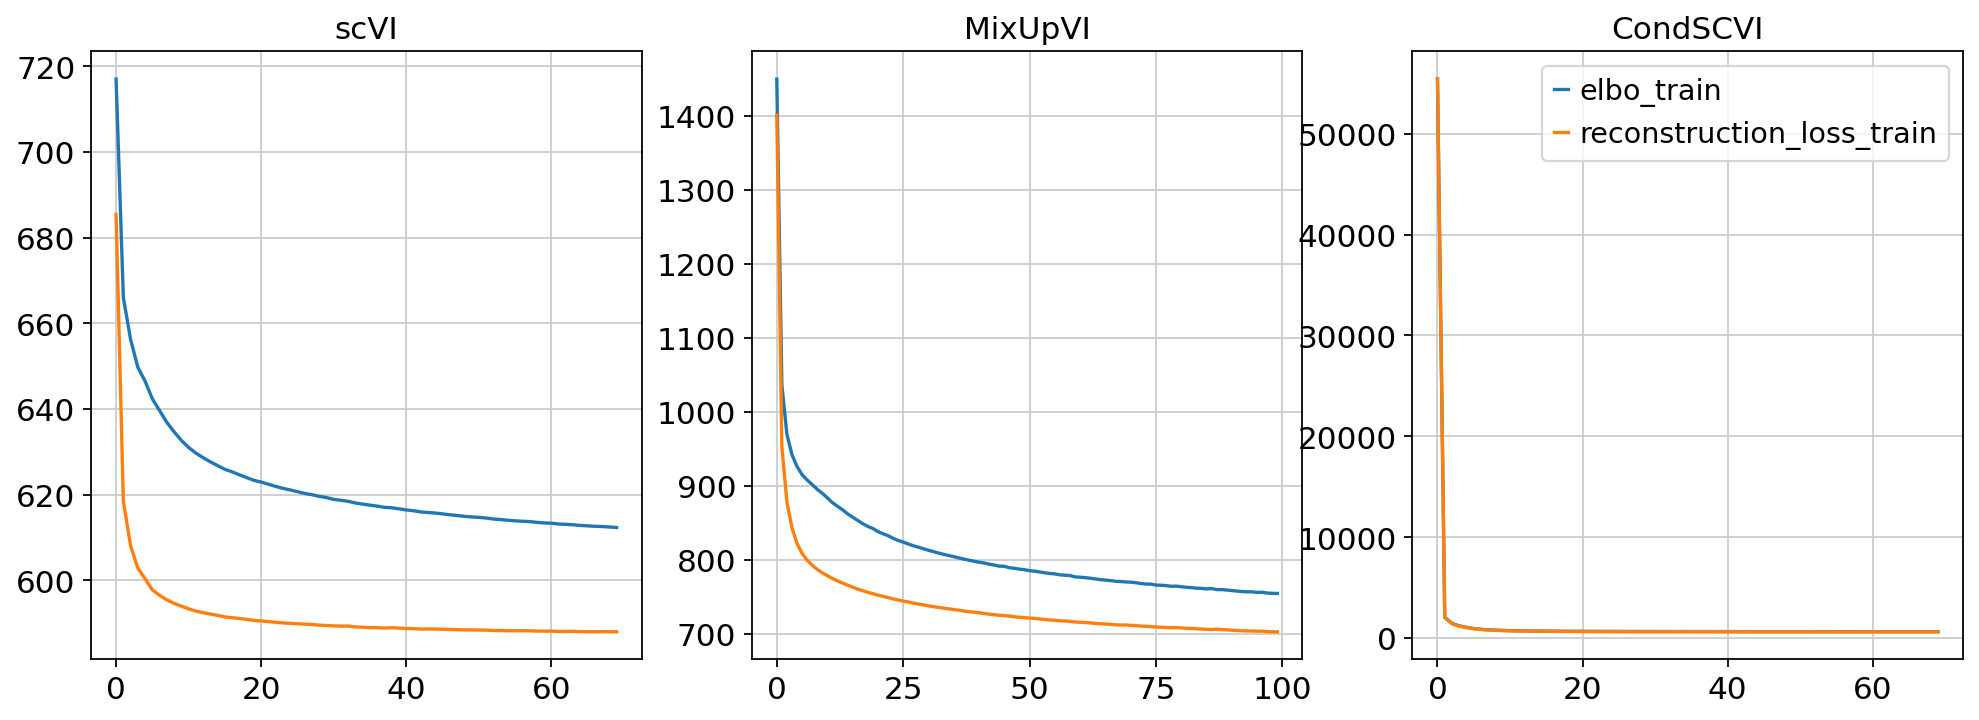

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(scvi_model.history["elbo_train"], label="elbo_train")
ax[0].plot(scvi_model.history["reconstruction_loss_train"], label="reconstruction_loss_train")
ax[0].set_title("scVI")

ax[1].plot(mixupvi_model.history["elbo_train"], label="elbo_train")
ax[1].plot(mixupvi_model.history["reconstruction_loss_train"], label="reconstruction_loss_train")
ax[1].set_title("MixUpVI")

ax[2].plot(condscvi_model.history["elbo_train"], label="elbo_train")
ax[2].plot(condscvi_model.history["reconstruction_loss_train"], label="reconstruction_loss_train")
ax[2].set_title("CondSCVI")

plt.legend()

#### KL divergence

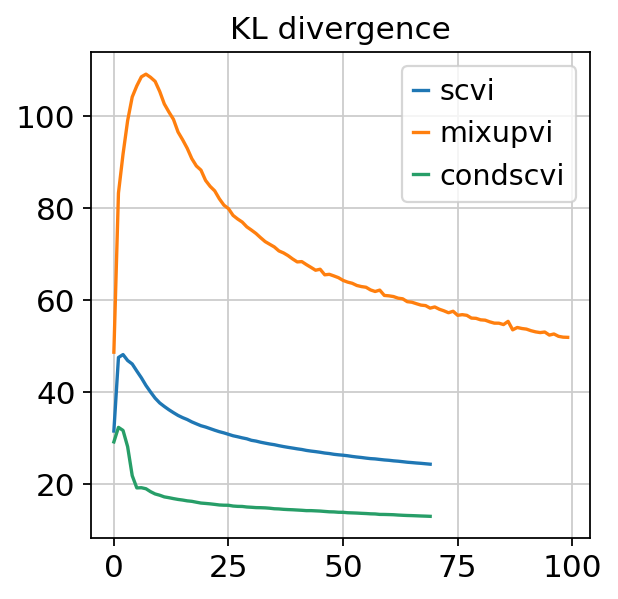

In [16]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plt.plot(scvi_model.history["kl_local_train"], label="scvi",)
plt.plot(mixupvi_model.history["kl_local_train"], label="mixupvi",)
plt.plot(condscvi_model.history["kl_local_train"], label="condscvi",)

plt.title("KL divergence")

plt.legend()

### Batch effects exploration

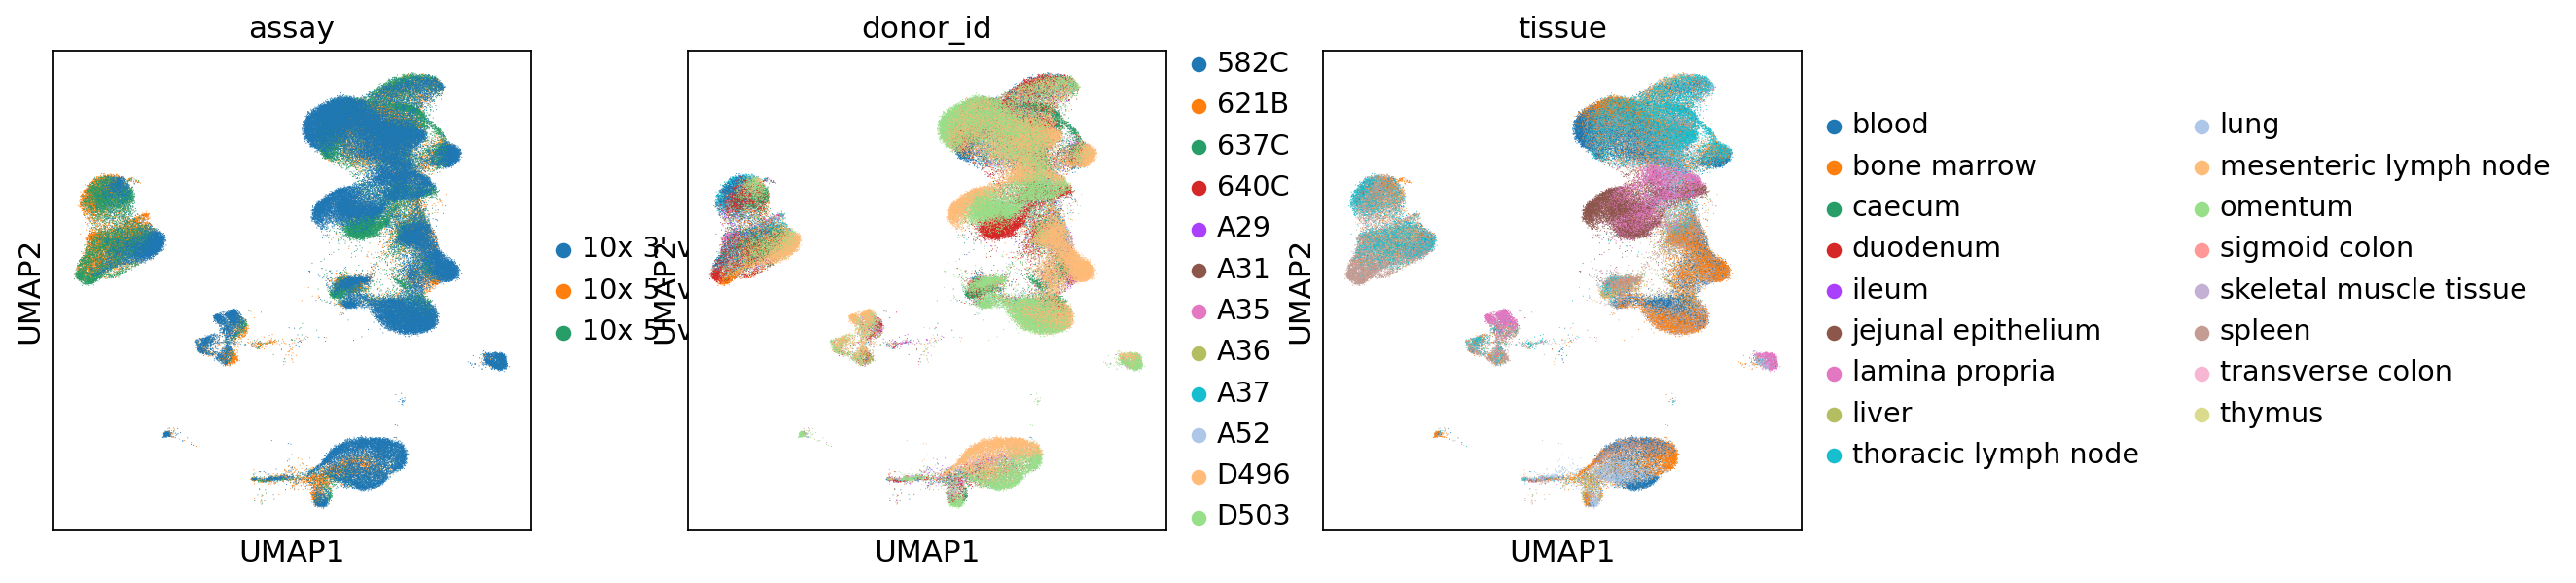

In [23]:
sc.pl.umap(adata_train,
          color=["assay", "donor_id", "tissue"]
          )

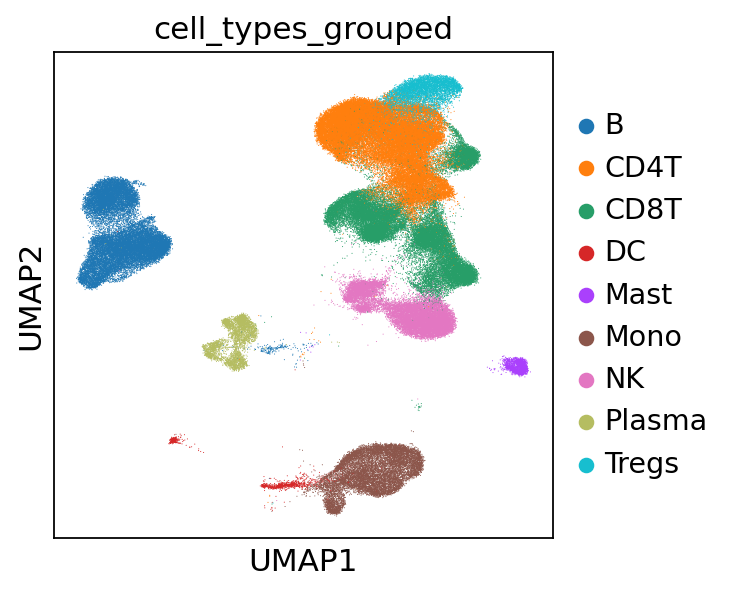

In [22]:
sc.pl.umap(adata_train,
          color=["cell_types_grouped"]
          )

### Latent space visualization

In [76]:
adata_pseudobulk_train_counts, _, df_proportions_train = create_dirichlet_pseudobulk_dataset(
    adata_train, prior_alphas = None, n_sample = 2000,
)

# scVI input
adata_pseudobulk_scvi = ad.AnnData(X=adata_pseudobulk_train_counts.layers["counts"],
                              obs=adata_pseudobulk_train_counts.obs,
                              var=adata_pseudobulk_train_counts.var)

adata_pseudobulk_scvi.layers["counts"] = adata_pseudobulk_scvi.X.copy()
adata_pseudobulk_scvi.obs["donor_id"] = "D503"
adata_pseudobulk_scvi.obs["assay"] = "10x 3' v3"
adata_pseudobulk_scvi.obs["tissue"] = "spleen"
adata_pseudobulk_scvi.obs["cell_type"] = "mixed"
adata_pseudobulk_scvi.obs["cell_types_grouped"] = "mixed"

# CondscVI input
adata_pseudobulk_condscvi = ad.AnnData(X=adata_pseudobulk_train_counts.layers["counts"],
                              obs=adata_pseudobulk_train_counts.obs,
                              var=adata_pseudobulk_train_counts.var)

adata_pseudobulk_condscvi.layers["counts"] = adata_pseudobulk_condscvi.X.copy()
adata_pseudobulk_condscvi.obs["cell_type"] = "mixed"
adata_pseudobulk_condscvi.obs["cell_types_grouped"] = "CD4T"

2024-01-22 14:18:38.344 | INFO     | benchmark_utils.dataset_utils:create_dirichlet_pseudobulk_dataset:215 - Creating dirichlet pseudobulk dataset...


In [82]:
# MixupVI input
adata_pseudobulk_mixupvi = ad.AnnData(X=adata_pseudobulk_train_counts.layers["counts"],
                              obs=adata_pseudobulk_train_counts.obs,
                              var=adata_pseudobulk_train_counts.var)

adata_pseudobulk_mixupvi.layers["counts"] = adata_pseudobulk_condscvi.X.copy()
adata_pseudobulk_mixupvi.obs["cell_type"] = "mixed"
adata_pseudobulk_mixupvi.obs["cell_types_grouped"] = "CD4T"

scVI

In [77]:
adata_full = ad.concat([adata_train, adata_pseudobulk_scvi]
                       )
adata_full.obsm["X_scvi"] = scvi_model.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [78]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata_full, 
                use_rep="X_scvi")
sc.tl.umap(adata_full, min_dist=0.3)

... storing 'donor_id' as categorical
... storing 'Predicted_labels_CellTypist' as categorical
... storing 'Majority_voting_CellTypist' as categorical
... storing 'Majority_voting_CellTypist_high' as categorical
... storing 'Manually_curated_celltype' as categorical
... storing 'assay_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'development_stage_ontology_term_id' as categorical
... storing 'disease_ontology_term_id' as categorical
... storing 'self_reported_ethnicity_ontology_term_id' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'sex_ontology_term_id' as categorical
... storing 'tissue_ontology_term_id' as categorical
... storing 'suspension_type' as categorical
... storing 'cell_type' as categorical
... storing 'assay' as categorical
... storing 'disease' as categorical
... storing 'organism' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'sel

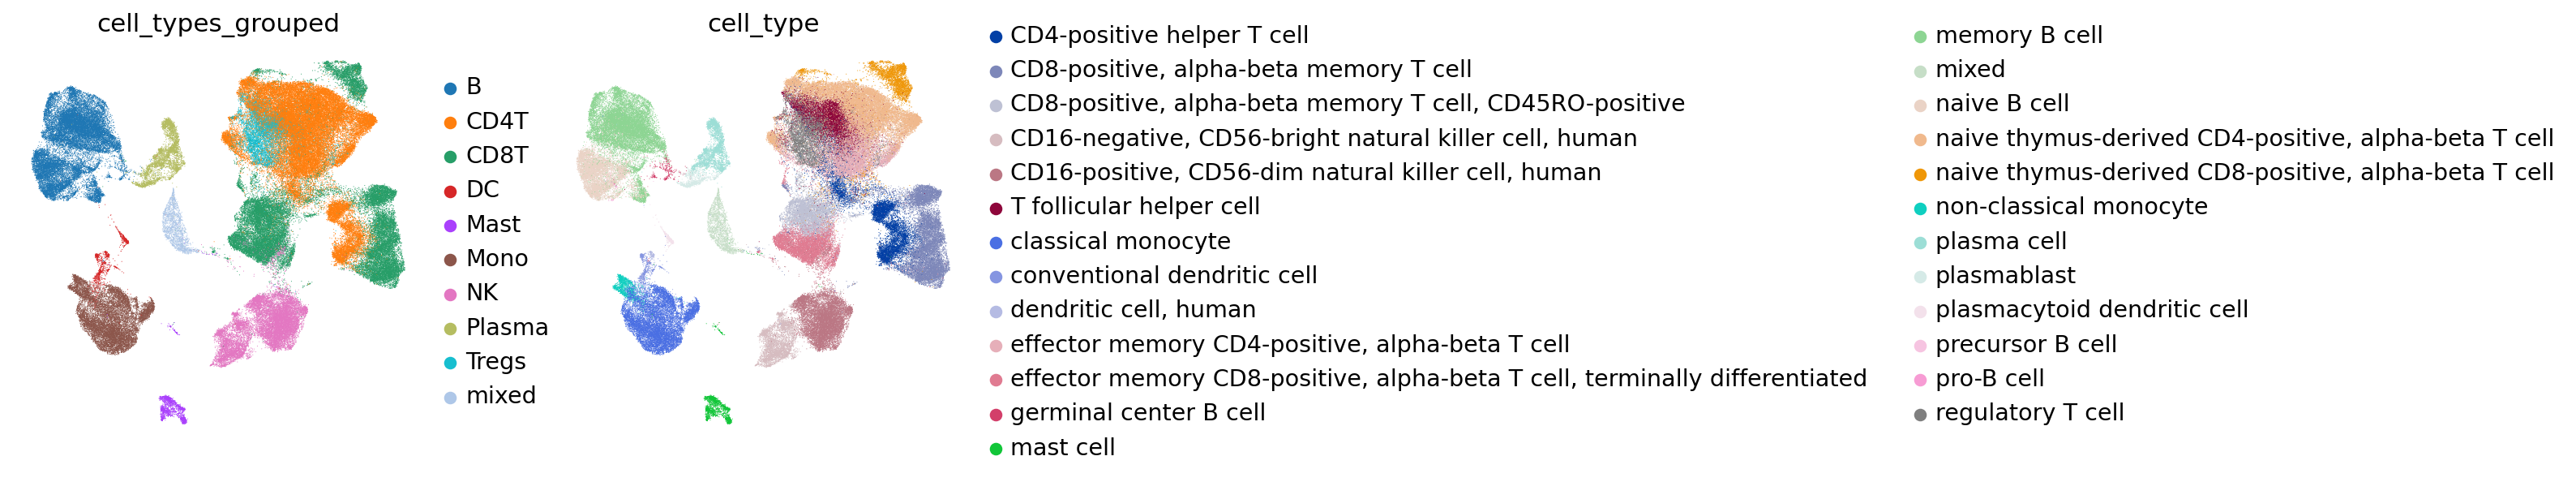

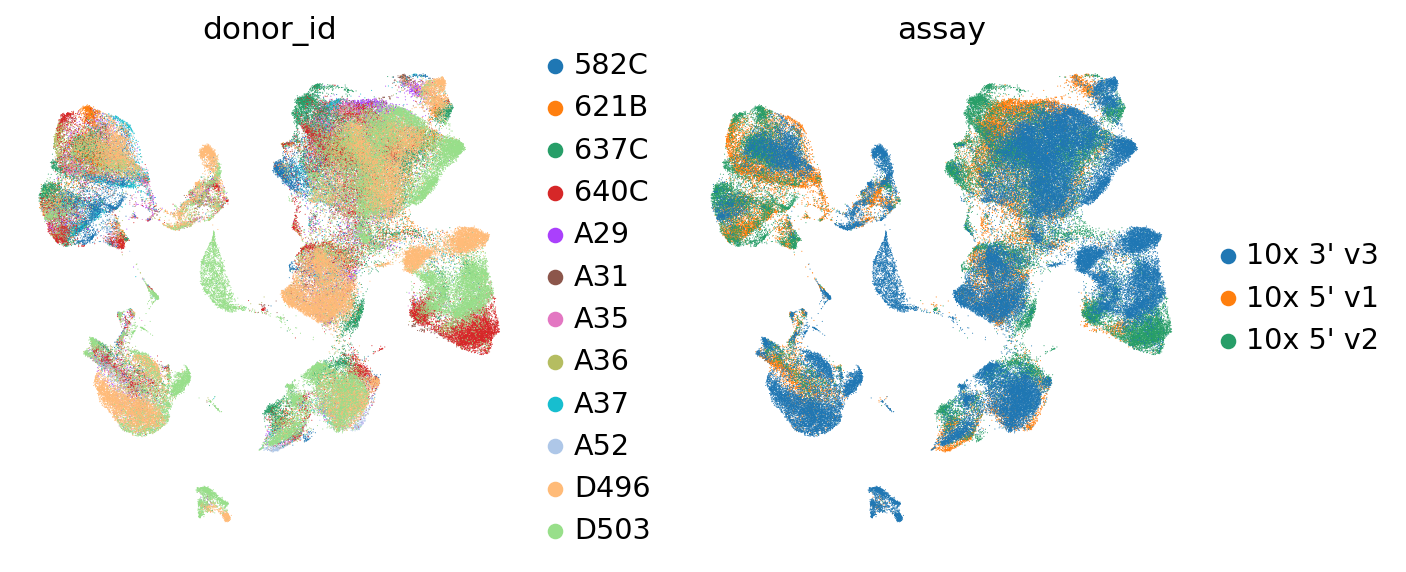

In [80]:
sc.pl.umap(
    adata_full,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata_full,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

MixupVI

In [83]:
adata_full = ad.concat([adata_train, adata_pseudobulk_mixupvi]
                       )
adata_full.obsm["X_mixupvi"] = mixupvi_model.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [85]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata_full, 
                use_rep="X_mixupvi")
sc.tl.umap(adata_full, min_dist=0.3)

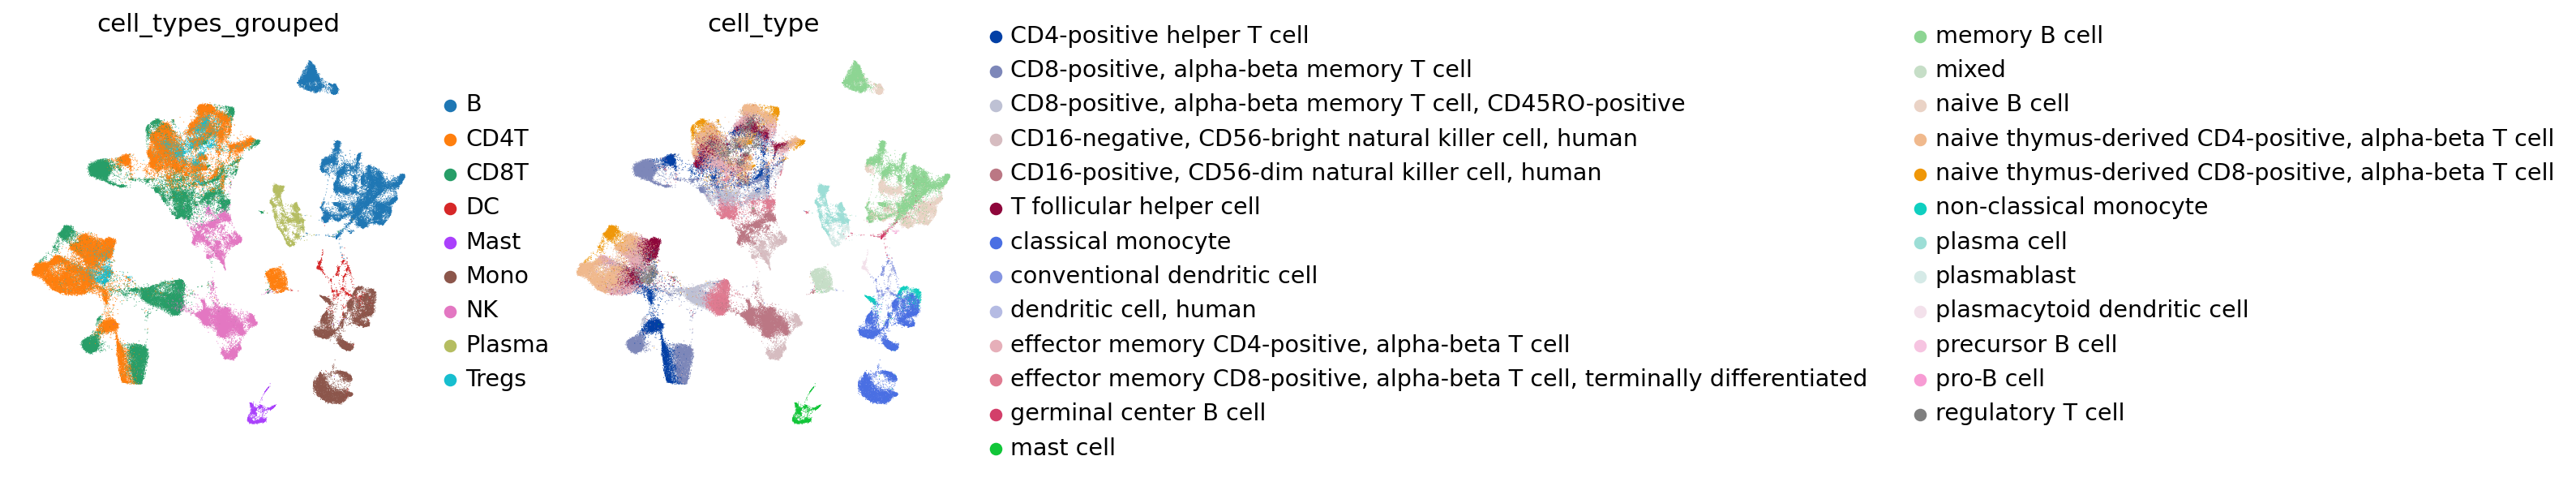

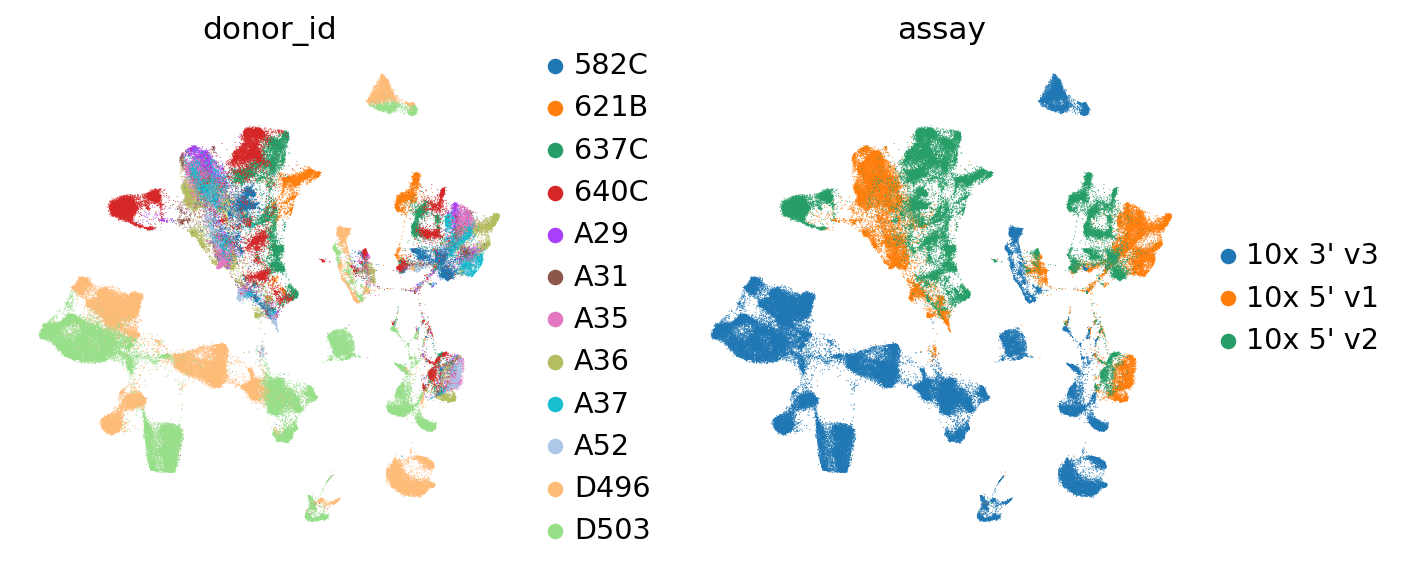

In [87]:
sc.pl.umap(
    adata_full,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata_full,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

In [41]:
# adata_train[adata_train.obs["cell_types_grouped"].isin(["CD4T", "CD8T"])].obs["donor_id"].value_counts()

CondscVI

In [88]:
adata_full = ad.concat([adata_train, adata_pseudobulk_condscvi]
                       )
adata_full.obsm["X_condscvi"] = condscvi_model.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [90]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata_full, 
                use_rep="X_condscvi")
sc.tl.umap(adata_full, min_dist=0.3)

... storing 'donor_id' as categorical
... storing 'Predicted_labels_CellTypist' as categorical


... storing 'Majority_voting_CellTypist' as categorical
... storing 'Majority_voting_CellTypist_high' as categorical
... storing 'Manually_curated_celltype' as categorical
... storing 'assay_ontology_term_id' as categorical
... storing 'cell_type_ontology_term_id' as categorical
... storing 'development_stage_ontology_term_id' as categorical
... storing 'disease_ontology_term_id' as categorical
... storing 'self_reported_ethnicity_ontology_term_id' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'sex_ontology_term_id' as categorical
... storing 'tissue_ontology_term_id' as categorical
... storing 'suspension_type' as categorical
... storing 'cell_type' as categorical
... storing 'assay' as categorical
... storing 'disease' as categorical
... storing 'organism' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'self_reported_ethnicity' as categorical
... storing 'development_stage' as categorical
... storing

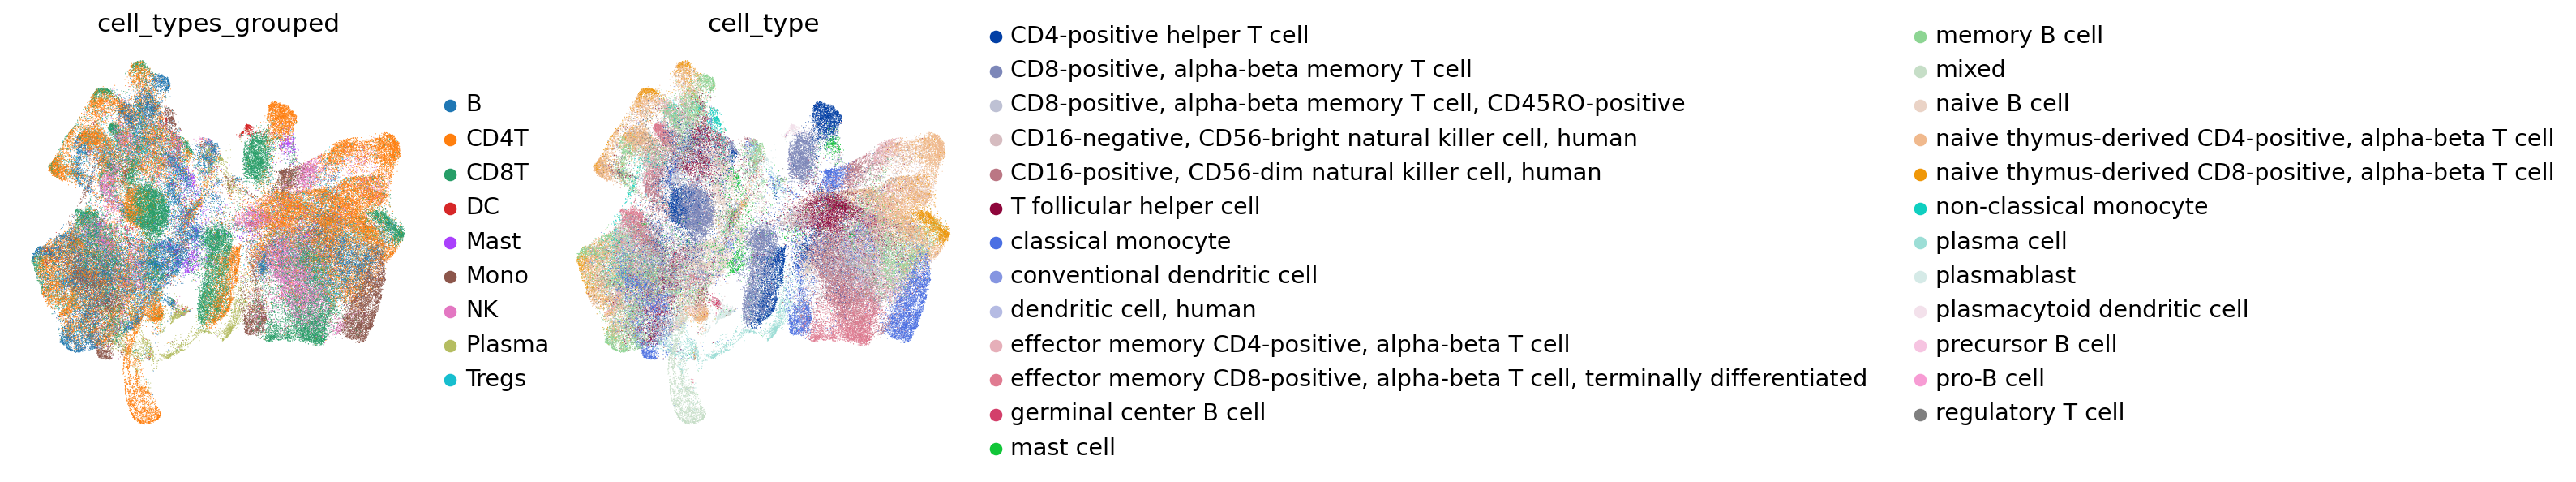

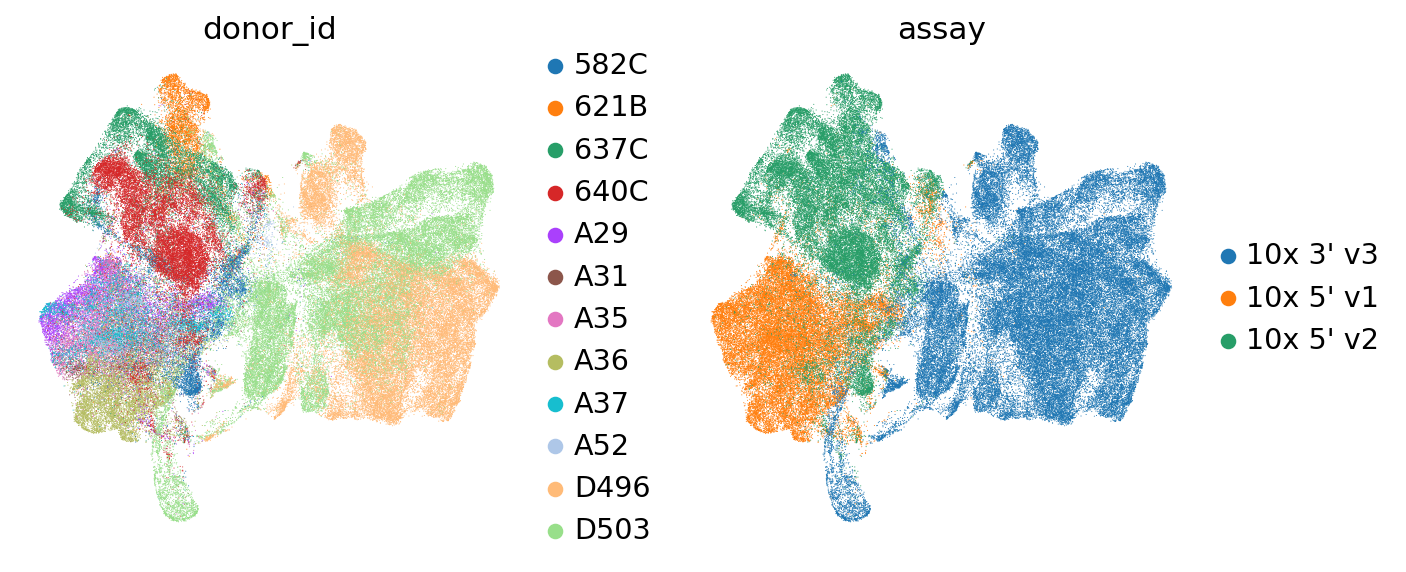

In [92]:
sc.pl.umap(
    adata_full,
    color=["cell_types_grouped", "cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata_full,
    color=["donor_id", "assay"],
    ncols=2,
    frameon=False,
)

Deconvolution

In [96]:
generative_models = {
    "scVI": scvi_model,
    "MixUpVI": mixupvi_model,
}

In [94]:
adata_pseudobulk_test_counts, _, df_proportions_test = create_dirichlet_pseudobulk_dataset(
        adata_test,
        prior_alphas = None,
        n_sample = 400,
        n_cells = 1000,
        add_sparsity=True
    )

2024-01-22 15:34:22.703 | INFO     | benchmark_utils.dataset_utils:create_dirichlet_pseudobulk_dataset:215 - Creating dirichlet pseudobulk dataset...


In [98]:
signature, intersection = create_signature(
    adata,
    signature_type=SIGNATURE_CHOICE,
)

In [125]:
model = "MixUpVI"

if model == "NNLS":
    deconv_results = perform_nnls(signature,
                                _[:, intersection])
else:
    adata_latent_signature = create_latent_signature(
        adata=adata_train,
        model=generative_models[model],
        average_all_cells = True,
        sc_per_pseudobulk=1000,
    )
    deconv_results = perform_latent_deconv(
        adata_pseudobulk=adata_pseudobulk_test_counts,
        adata_latent_signature=adata_latent_signature,
        model=generative_models[model],
    )

deconv_results

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer

CD4T      CD8T         B    Plasma        DC        NK  \
sample_0    0.079033  0.008060  0.073435  0.221547  0.047563  0.104633   
sample_1    0.161207  0.185044  0.076921  0.045572  0.050548  0.138705   
sample_2    0.003631  0.288814  0.082908  0.050687  0.197205  0.029606   
sample_3    0.065194  0.286762  0.040697  0.169694  0.020611  0.161772   
sample_4    0.138243  0.176020  0.067358  0.082856  0.014557  0.006453   
...              ...       ...       ...       ...       ...       ...   
sample_395  0.148315  0.091745  0.074712  0.156167  0.070477  0.121546   
sample_396  0.074241  0.133977  0.018168  0.167640  0.211773  0.150749   
sample_397  0.102627  0.197483  0.041872  0.147779  0.055036  0.128522   
sample_398  0.058089  0.265076  0.048232  0.187122  0.100593  0.039209   
sample_399  0.096611  0.089064  0.082840  0.185260  0.061900  0.114653   

                Mono      Mast     Tregs  
sample_0    0.237867  0.022189  0.205672  
sample_1    0.110213  0.120426  0.111365  
sample_2    0.028718  0.275335  0.043097  
sample_3    0.136243  0.106394  0.012633  
sample_4    0.307099  0.013734  0.193679  
...              ...       ...       ...  
sample_395  0.225784  0.066337  0.044918  
sample_396  0.079198  0.069939  0.094316  
sample_397  0.167746  0.077880  0.081055  
sample_398  0.137096  0.103173  0.061410  
sample_399  0.125535  0.093076  0.151061  

[400 rows x 9 columns]

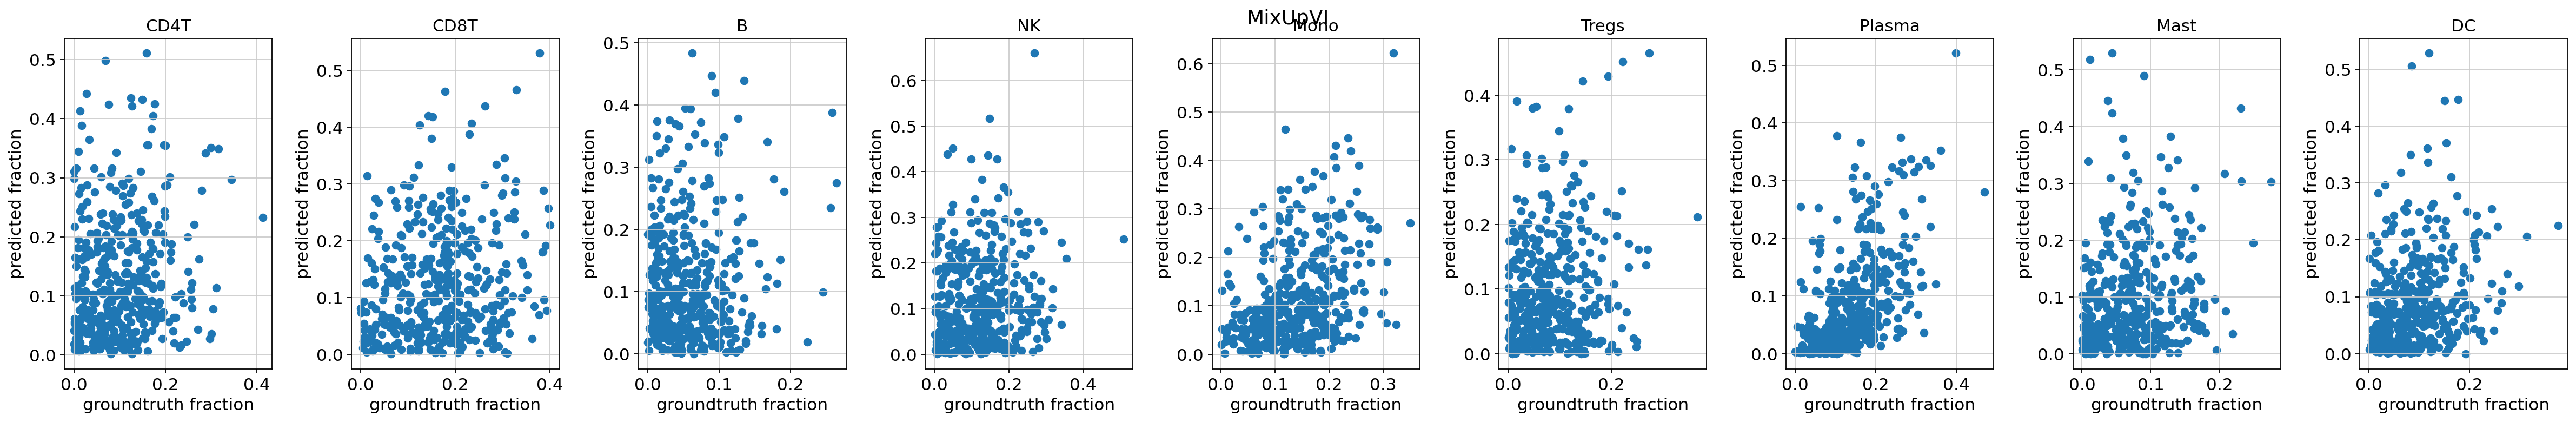

In [126]:
# Get the column names from both DataFrames
columns_df1 = df_proportions_test.columns
columns_df2 = deconv_results.columns

# Check if the columns are the same in both DataFrames
if not set(columns_df1) == set(columns_df2):
    raise ValueError("Column names are not the same in both DataFrames")

# Create a subplot grid
num_columns = len(columns_df1)
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(30, 5))  # Adjust the figsize as needed

# Iterate over each column and create a scatterplot
for i, column in enumerate(columns_df1):
    ax = axes[i] if num_columns > 1 else axes  # Use the appropriate axis for single-column case
    ax.scatter(deconv_results[column], df_proportions_test[column])
    ax.set_title(column)
    ax.set_xlabel(f'groundtruth fraction')
    ax.set_ylabel(f'predicted fraction')

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle(model)

# Show the plot
plt.show()